In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from estimator import TFTEstimator

/home/kashif/.env/pytorch/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
dataset = get_dataset("traffic")

In [5]:
dataset

TrainDatasets(metadata=MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='862')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24), train=<gluonts.dataset.common.FileDataset object at 0x7fe8c7dafc40>, test=<gluonts.dataset.common.FileDataset object at 0x7fe8c7dafe20>)

In [16]:
estimator = TFTEstimator(
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    num_feat_static_cat=1,
    cardinality=[862],
    
    scaling=False,

    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=50, accelerator='gpu', gpus=1),
)

In [17]:
predictor = estimator.train(
    training_data=dataset.train,
    num_workers=8,
    shuffle_buffer_length=1024
)

/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `valida

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached -1.76367 (best -1.76367), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/tft/lightning_logs/version_40/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached -2.67806 (best -2.67806), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/tft/lightning_logs/version_40/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached -2.82263 (best -2.82263), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/tft/lightning_logs/version_40/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached -2.91125 (best -2.91125), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/tft/lightning_logs/version_40/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached -3.00680 (best -3.00680), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/tft/lightning_logs/version_40/checkpoin

In [18]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor
)

In [19]:
forecasts = list(forecast_it)

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base


In [10]:
tss = list(ts_it)

In [20]:
evaluator = Evaluator()

In [21]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 6034it [00:00, 10921.04it/s]/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq 

In [22]:
agg_metrics

{'MSE': 0.000649330164079505,
 'abs_error': 1432.974686332047,
 'abs_target_sum': 8672.5710073933,
 'abs_target_mean': 0.0598868288545002,
 'seasonal_error': 0.015220711169889631,
 'MASE': 0.648407474736938,
 'MAPE': 0.2660992923204324,
 'sMAPE': 0.2139038286564818,
 'MSIS': 7.822711779756906,
 'QuantileLoss[0.1]': 758.046953115314,
 'Coverage[0.1]': 0.035451883769749205,
 'QuantileLoss[0.2]': 1091.1472629882426,
 'Coverage[0.2]': 0.07841674953043862,
 'QuantileLoss[0.3]': 1288.6517700438721,
 'Coverage[0.3]': 0.1443072588664236,
 'QuantileLoss[0.4]': 1394.0904395095831,
 'Coverage[0.4]': 0.23985609324936472,
 'QuantileLoss[0.5]': 1432.9746841261403,
 'Coverage[0.5]': 0.366036901999779,
 'QuantileLoss[0.6]': 1426.1454076143127,
 'Coverage[0.6]': 0.49707905203844877,
 'QuantileLoss[0.7]': 1358.4131771848538,
 'Coverage[0.7]': 0.6520481162302508,
 'QuantileLoss[0.8]': 1218.5885981488536,
 'Coverage[0.8]': 0.8036611976577173,
 'QuantileLoss[0.9]': 944.6292773525245,
 'Coverage[0.9]': 0.91

In [13]:
agg_metrics

{'MSE': 0.0008602817230717296,
 'abs_error': 1617.4472325854003,
 'abs_target_sum': 8672.5710073933,
 'abs_target_mean': 0.0598868288545002,
 'seasonal_error': 0.015220711169889631,
 'MASE': 0.7225524827690298,
 'MAPE': 0.21059109221974529,
 'sMAPE': 0.17548061777599777,
 'MSIS': 7.981380574607891,
 'QuantileLoss[0.1]': 798.1957122146287,
 'Coverage[0.1]': 0.05049856369461938,
 'QuantileLoss[0.2]': 1163.7939581929065,
 'Coverage[0.2]': 0.1206703679151475,
 'QuantileLoss[0.3]': 1394.4469597546472,
 'Coverage[0.3]': 0.19998480830847423,
 'QuantileLoss[0.4]': 1541.6169008201734,
 'Coverage[0.4]': 0.2855209369130483,
 'QuantileLoss[0.5]': 1617.447230679832,
 'Coverage[0.5]': 0.37727184841453987,
 'QuantileLoss[0.6]': 1641.2588065576676,
 'Coverage[0.6]': 0.46351922439509446,
 'QuantileLoss[0.7]': 1565.8052165220274,
 'Coverage[0.7]': 0.5644956358413434,
 'QuantileLoss[0.8]': 1386.698439198728,
 'Coverage[0.8]': 0.6784195116561705,
 'QuantileLoss[0.9]': 1048.4756686581238,
 'Coverage[0.9]':

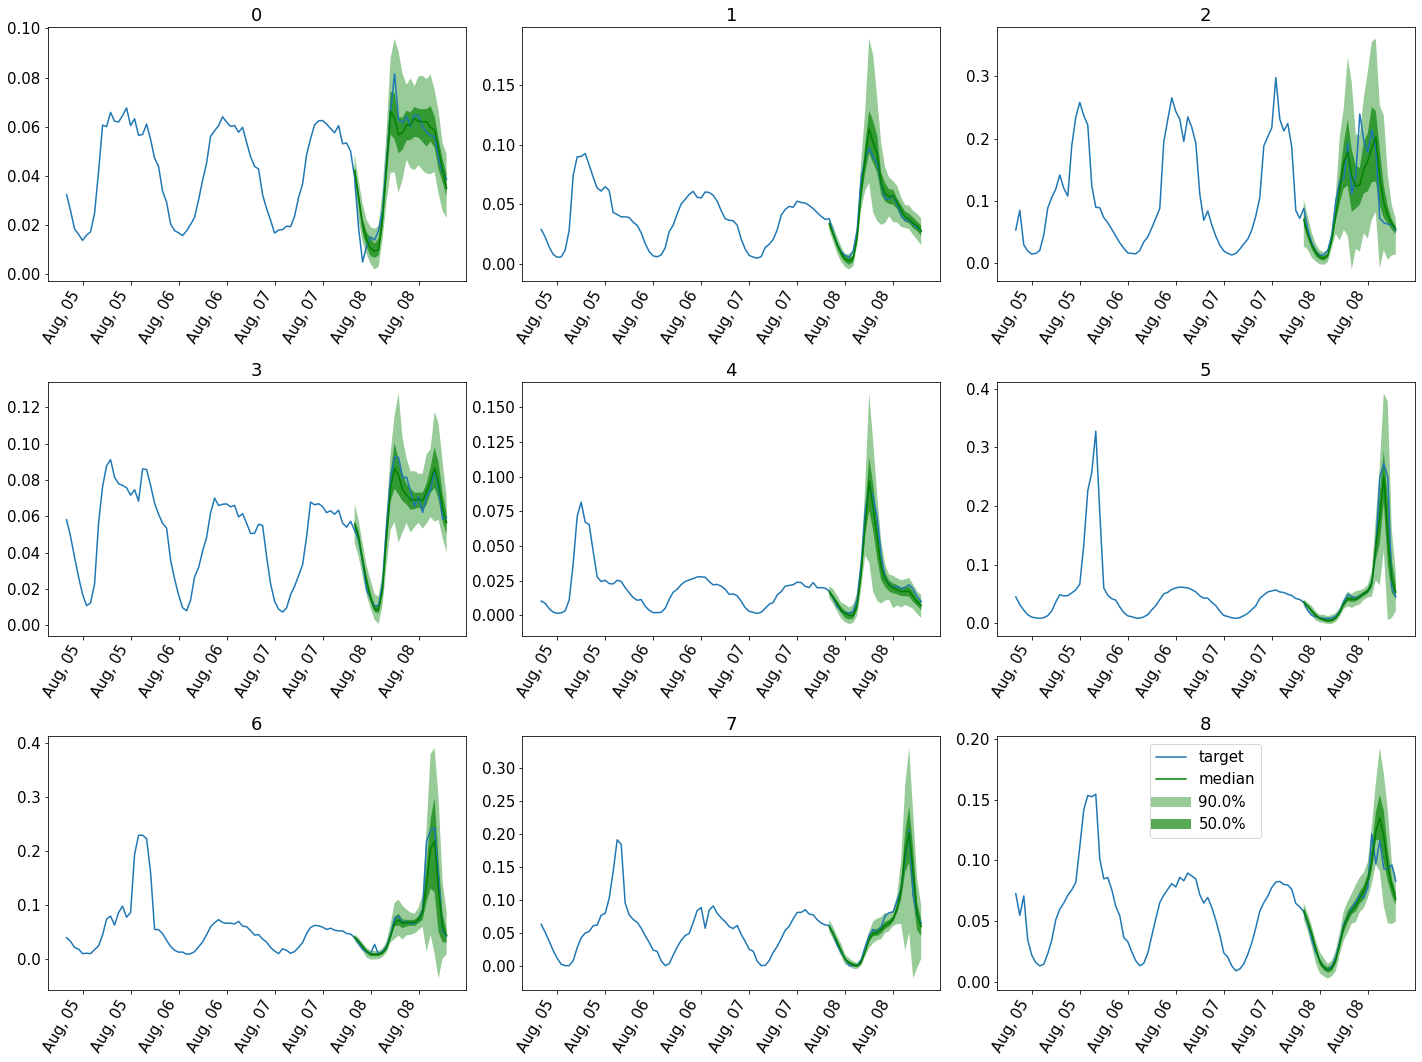

In [23]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:], label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()